# This model aims to predict whether the stock tick is going to be negative or positive gain so that we can make appropriate investing action.

# The model used in this notebook is Long Short Term Memory (artificial recurrent network)

In [ ]:
# Install API package 
!pip install alpaca_trade_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import alpaca_trade_api as alpacatrade
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


# API keys and connection establish

In [ ]:
base_url = 'https://paper-api.alpaca.markets'
api_key = "PK7WZLWPRI3DIXSU2AKB"
api_secret_key = "zrSjMJgKOcyGIbpPViPzwlrQFpeLSapdg8kj6j25"

In [ ]:
# Create a connection with Rest API
api = alpacatrade.REST(key_id= api_key, secret_key= api_secret_key, base_url= base_url)

# Test out the connection by calling account

In [ ]:
# Fetch Account
account = api.get_account()
# Print Account Details
print(account.id, account.equity, account.status)

a9bfbcba-fe38-4333-969f-3cfc458c3000 100000 ACTIVE


# Fetch Market data

In [ ]:
# Setting parameters for code calling
symbol = "AAPL"
timeframe = "1Minute"
start = "2022-01-01"
end = "2023-01-01" # YYYY-MM-DD
# Using bar data method
apple_bars = api.get_bars(symbol, timeframe, start, end).df
# get only market hours
apple_bars = apple_bars.between_time('9:30', '16:00')
print(apple_bars.head(10))

                             open    high     low   close  volume  \
timestamp                                                           
2022-01-03 09:30:00+00:00  177.87  177.87  177.87  177.87     467   
2022-01-03 09:31:00+00:00  177.87  177.87  177.80  177.80     634   
2022-01-03 09:32:00+00:00  177.80  177.80  177.80  177.80    1047   
2022-01-03 09:33:00+00:00  177.76  177.76  177.76  177.76     633   
2022-01-03 09:34:00+00:00  177.77  177.85  177.77  177.85     958   
2022-01-03 09:36:00+00:00  177.85  177.88  177.81  177.81    1644   
2022-01-03 09:37:00+00:00  177.81  177.81  177.80  177.81    1364   
2022-01-03 09:38:00+00:00  177.80  177.80  177.80  177.80     563   
2022-01-03 09:39:00+00:00  177.83  177.84  177.77  177.77    2278   
2022-01-03 09:40:00+00:00  177.83  177.84  177.83  177.84     850   

                           trade_count        vwap  
timestamp                                           
2022-01-03 09:30:00+00:00           17  177.871842  
2022-01-03 0

In [ ]:
# convert dataframe to Pandas
pd.DataFrame(apple_bars)

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:30:00+00:00,177.8700,177.8700,177.870,177.8700,467,17,177.871842
2022-01-03 09:31:00+00:00,177.8700,177.8700,177.800,177.8000,634,20,177.817618
2022-01-03 09:32:00+00:00,177.8000,177.8000,177.800,177.8000,1047,59,177.804413
2022-01-03 09:33:00+00:00,177.7600,177.7600,177.760,177.7600,633,50,177.768815
2022-01-03 09:34:00+00:00,177.7700,177.8500,177.770,177.8500,958,11,177.808173
...,...,...,...,...,...,...,...
2022-12-30 15:56:00+00:00,128.8192,128.8400,128.710,128.7508,135152,1248,128.790486
2022-12-30 15:57:00+00:00,128.7500,128.7600,128.626,128.6650,147990,1524,128.698747
2022-12-30 15:58:00+00:00,128.6675,128.7300,128.600,128.6850,137146,1194,128.685074


# Data exploratory

In [ ]:
# size of the data
apple_bars.shape[0]

83010

In [ ]:
# Data type of each column
apple_bars.dtypes

open           float64
high           float64
low            float64
close          float64
volume           int64
trade_count      int64
vwap           float64
dtype: object

# Data Wrangling
return variable = (close - open)/open to get percentage gains. => used this to as a condition to create target variable.

We called Target variable "Direction" which is decided based on if Gains >= 0, then it is 'Positive', otherwise, it is 'Negative'.

Wants data from 9:30am to 4:00pm. Starts at 9:31

In [ ]:
#  Create a new column that contains gains value of each call every minute
apple_bars["Gains (%)"]= (apple_bars["close"]- apple_bars["open"])/apple_bars["open"]
apple_bars

,open,high,low,close,volume,trade_count,vwap,Gains (%)
timestamp,,,,,,,,
2022-01-03 09:30:00+00:00,177.8700,177.8700,177.870,177.8700,467,17,177.871842,0.000000
2022-01-03 09:31:00+00:00,177.8700,177.8700,177.800,177.8000,634,20,177.817618,-0.000394
2022-01-03 09:32:00+00:00,177.8000,177.8000,177.800,177.8000,1047,59,177.804413,0.000000
2022-01-03 09:33:00+00:00,177.7600,177.7600,177.760,177.7600,633,50,177.768815,0.000000
2022-01-03 09:34:00+00:00,177.7700,177.8500,177.770,177.8500,958,11,177.808173,0.000450
...,...,...,...,...,...,...,...,...
2022-12-30 15:56:00+00:00,128.8192,128.8400,128.710,128.7508,135152,1248,128.790486,-0.000531
2022-12-30 15:57:00+00:00,128.7500,128.7600,128.626,128.6650,147990,1524,128.698747,-0.000660
2022-12-30 15:58:00+00:00,128.6675,128.7300,128.600,128.6850,137146,1194,128.685074,0.000136


In [ ]:
# 0 number of missing values in the dataset
apple_bars.isna().sum()

open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
Gains (%)      0
dtype: int64

In [ ]:
# Create a new 'Direction' column based on Gains 
apple_bars["Direction"] = np.where(apple_bars["Gains (%)"] >= 0, "Positive", "Negative")
apple_bars

,open,high,low,close,volume,trade_count,vwap,Gains (%),Direction
timestamp,,,,,,,,,
2022-01-03 09:30:00+00:00,177.8700,177.8700,177.870,177.8700,467,17,177.871842,0.000000,Positive
2022-01-03 09:31:00+00:00,177.8700,177.8700,177.800,177.8000,634,20,177.817618,-0.000394,Negative
2022-01-03 09:32:00+00:00,177.8000,177.8000,177.800,177.8000,1047,59,177.804413,0.000000,Positive
2022-01-03 09:33:00+00:00,177.7600,177.7600,177.760,177.7600,633,50,177.768815,0.000000,Positive
2022-01-03 09:34:00+00:00,177.7700,177.8500,177.770,177.8500,958,11,177.808173,0.000450,Positive
...,...,...,...,...,...,...,...,...,...
2022-12-30 15:56:00+00:00,128.8192,128.8400,128.710,128.7508,135152,1248,128.790486,-0.000531,Negative
2022-12-30 15:57:00+00:00,128.7500,128.7600,128.626,128.6650,147990,1524,128.698747,-0.000660,Negative
2022-12-30 15:58:00+00:00,128.6675,128.7300,128.600,128.6850,137146,1194,128.685074,0.000136,Positive


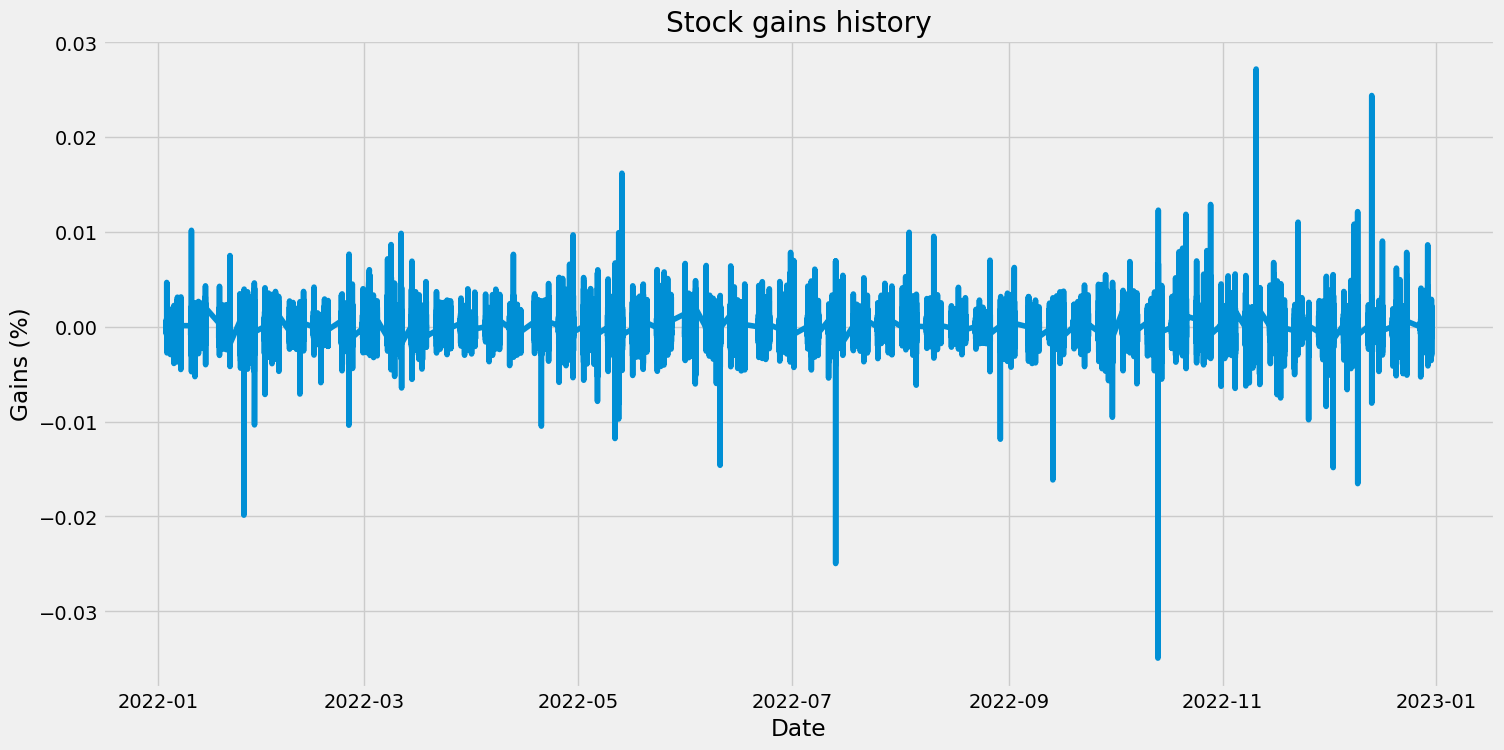

In [ ]:
# Visualize the Gains history
plt.figure(figsize = (16,8))
plt.title("Stock gains history")
plt.plot(apple_bars["Gains (%)"])
plt.xlabel("Date")
plt.ylabel("Gains (%)")
plt.show()

# It is always a good thing to preprocess the input data before introduce it to a ML model

Neural net dont' really work with anything else beside integer.

In [ ]:
# Get the number of rows to train the model on
train_size = math.ceil(len(apple_bars)* .8) # round up with math.ceil. 80-20 split
test_size = len(apple_bars) - train_size
train, test = apple_bars.iloc[0: train_size], apple_bars.iloc[train_size:]

print(train.shape, test.shape) # shape adds up to 83,010

(66408, 9) (16602, 9)


In [ ]:
# Scaling the data to make all columns on the same scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

x_columns = ["open", "high", "low", 'close', "volume", 'vwap', 'trade_count', "Gains (%)"]

x_transformer = RobustScaler()
y_encoder = LabelEncoder() # encode as integers of 1 or 0

x_train_transformer = x_transformer.fit(train[x_columns].to_numpy())
#y_train_transformer = y_transformer.fit(train[['Direction']])
y_encoder.fit(train["Direction"])


train.loc[:, x_columns] = x_train_transformer.transform(train[x_columns].to_numpy())
train["Direction"] = y_encoder.transform(train[["Direction"]])


test.loc[:, x_columns] = x_train_transformer.transform(test[x_columns].to_numpy())
test["Direction"] = y_encoder.transform(test[["Direction"]])

<ipython-input-184-197b1aeeace6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, x_columns] = x_train_transformer.transform(train[x_columns].to_numpy())
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
<ipython-input-184-197b1aeeace6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [ ]:
train['Direction']

timestamp
2022-01-03 09:30:00+00:00    1
2022-01-03 09:31:00+00:00    0
2022-01-03 09:32:00+00:00    1
2022-01-03 09:33:00+00:00    1
2022-01-03 09:34:00+00:00    1
                            ..
2022-10-14 16:00:00+00:00    0
2022-10-17 09:30:00+00:00    0
2022-10-17 09:31:00+00:00    1
2022-10-17 09:32:00+00:00    0
2022-10-17 09:34:00+00:00    1
Name: Direction, Length: 66408, dtype: int64

# Create subsequences of time series for third dimension

In [ ]:
def create_dataset(X, y, time_steps = 1):
  Xs, ys = [], []
  for i in range(len(X)- time_steps): # correct number of iteration because we will not be using the last however many time steps we specified. Shift down.
    v = X.iloc[i:(i+time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)


In [ ]:
Time_steps = 5 # 5 minutes subsequence

x_train, y_train = create_dataset(train, train.Direction, time_steps = Time_steps)
x_test, y_test = create_dataset(test, test.Direction, time_steps = Time_steps)


In [ ]:
# [samples, time_steps, number of features] are the 3 dimensions for LSTM model
print(x_train.shape, y_train.shape)

(66403, 5, 9) (66403,)


In [ ]:
print(x_test.shape, y_test.shape)

(16597, 5, 9) (16597,)


In [ ]:
x_test

array([[[-0.90681495, -0.90879017, -0.90266741, ..., -0.90637787,
          0.        ,  1.        ],
        [-0.90634191, -0.90831758, -0.90219407, ..., -0.90607539,
          0.        ,  1.        ],
        [-0.90539583, -0.9073724 , -0.90550748, ..., -0.90746631,
         -1.02219984,  0.        ],
        [-0.90965318, -0.91162571, -0.90598082, ..., -0.909606  ,
         -0.11365081,  0.        ],
        [-0.90823406, -0.91020794, -0.90408745, ..., -0.90770097,
          0.        ,  1.        ]],

       [[-0.90634191, -0.90831758, -0.90219407, ..., -0.90607539,
          0.        ,  1.        ],
        [-0.90539583, -0.9073724 , -0.90550748, ..., -0.90746631,
         -1.02219984,  0.        ],
        [-0.90965318, -0.91162571, -0.90598082, ..., -0.909606  ,
         -0.11365081,  0.        ],
        [-0.90823406, -0.91020794, -0.90408745, ..., -0.90770097,
          0.        ,  1.        ],
        [-0.90681495, -0.90879017, -0.90266741, ..., -0.90666677,
          0.  

In [ ]:
y_test

array([1, 0, 1, ..., 1, 1, 0])

# Build LSTM model.Means that it will look into both past and future data to learn.

In [ ]:
# Initiate LSTM model
model = Sequential()
model.add(
        LSTM(
            units = 150,
            input_shape = (x_train.shape[1], x_train.shape[2])
        )
    )
model.add(Dropout(rate = .2))
model.add(Dense(units = 1, activation = 'sigmoid')) # number of output we want to predict. In this case, we only want 1 output.

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy']) # the smaller the better

In [ ]:
# fit the model into the training set
fit = model.fit(
    x_train, y_train,
    epochs = 5, # similar to cross validation. the amount of time the training data is used by the model. Iteration time.
    batch_size = 5, # how many samples are used for each time step
    validation_split = .1,
    shuffle = False
)

Epoch 1/5
11953/11953 [==============================] - 119s 9ms/step - loss: 0.6803 - accuracy: 0.5625 - val_loss: 0.6781 - val_accuracy: 0.5561
Epoch 2/5
11953/11953 [==============================] - 112s 9ms/step - loss: 0.6758 - accuracy: 0.5628 - val_loss: 0.6765 - val_accuracy: 0.5562
Epoch 3/5
11953/11953 [==============================] - 109s 9ms/step - loss: 0.6739 - accuracy: 0.5643 - val_loss: 0.6763 - val_accuracy: 0.5576
Epoch 4/5
11953/11953 [==============================] - 107s 9ms/step - loss: 0.6731 - accuracy: 0.5655 - val_loss: 0.6764 - val_accuracy: 0.5553
Epoch 5/5
11953/11953 [==============================] - 110s 9ms/step - loss: 0.6723 - accuracy: 0.5671 - val_loss: 0.6759 - val_accuracy: 0.5585


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test) # 59% accuracy

519/519 [==============================] - 4s 5ms/step - loss: 0.6607 - accuracy: 0.5901


In [ ]:
predict = model.predict(x_test)
y_pred_binary = (predict >= 0.5).astype(int) # anything that is >= .5 will return a 1

519/519 [==============================] - 4s 7ms/step


In [ ]:
# Revert the ys data to original format to compare
# y_train_inv = y_transformer.inverse_transform(y_train.reshape(1,-1))
# y_test_inv = y_transformer.inverse_transform(y_test.reshape(1,-1))
# predict_inv = y_transformer.inverse_transform(predict)

In [ ]:
y_test = pd.DataFrame(y_test.T)
y_pred_binary_df =pd.DataFrame(y_pred_binary)

In [ ]:
y_test

,0
0,1
1,0
2,1
3,0
4,1
...,...
16592,0
16593,0
16594,1
16595,1


In [ ]:
y_pred_binary_df

,0
0,1
1,1
2,1
3,1
4,1
...,...
16592,1
16593,1
16594,1
16595,1


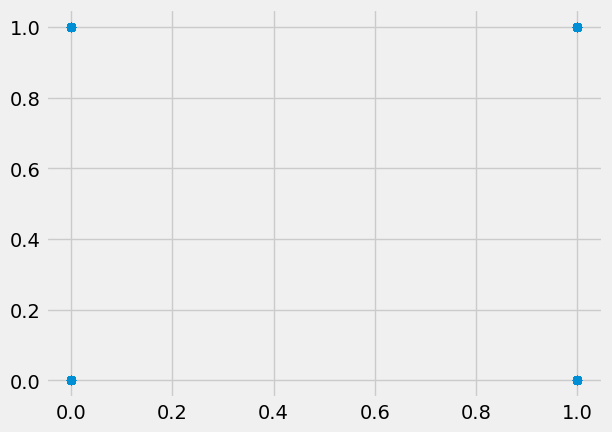

In [ ]:
plt.scatter(y_test, y_pred_binary_df)

# Confusion matrix


In [ ]:
final_result = pd.concat((y_test,y_pred_binary_df), axis = 1,ignore_index=True)

In [ ]:
final_result

,0,1
0,1,1
1,0,1
2,1,1
3,0,1
4,1,1
...,...,...
16592,0,1
16593,0,1
16594,1,1
16595,1,1


In [ ]:
final_result.rename(columns = {0:'y_test', 1:'y_predict'}, inplace=True)

In [ ]:
final_result.columns

Index(['y_test', 'y_predict'], dtype='object')

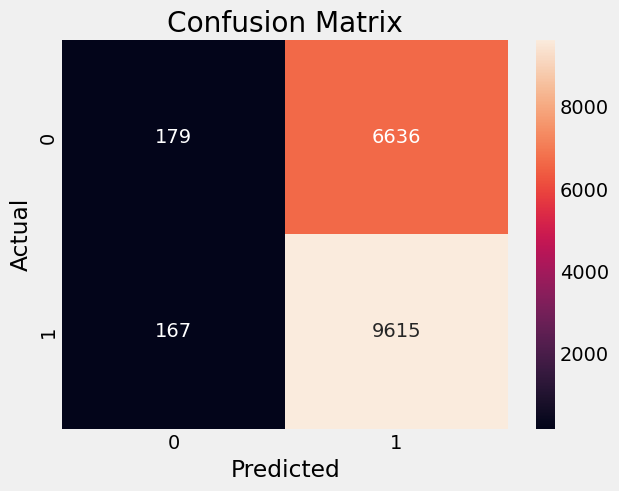

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create a confusion matrix
cm = confusion_matrix(final_result['y_test'], final_result['y_predict'])
# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

My model is more favor to predict Positive as an answer. A potential solution is to introduce more data in the feature variables or tune the data a bit more, such as more epochs, less batch size,... etc.

# LSTM model building source reference:

https://datascience.stackexchange.com/questions/60017/lstm-to-multivariate-sequence-classification

https://www.youtube.com/watch?v=xaIA83x5Icg

https://nam11.safelinks.protection.outlook.com/?url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F04%2Fintroduction-to-softmax-for-neural-network%2F&data=05%7C01%7Cnguye2dc%40mail.uc.edu%7C8b6c45f4e8f0448464bf08db4c443643%7Cf5222e6c5fc648eb8f0373db18203b63%7C0%7C0%7C638187628130706776%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000%7C%7C%7C&sdata=cjXPr0KuwLOKtDNX7qFvmAf0uMhZtCRwg4F4FmwL4rI%3D&reserved=0

https://www.kaggle.com/code/urbanbricks/keras-lstm-for-document-classification

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/